In [1]:
!pip install pytorch-lightning -qq

## Dependencies

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import QMNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.callbacks.progress import TQDMProgressBar

## Args

In [3]:
random_seed = 42
torch.manual_seed(random_seed)
batch_size= 128

NUM_WORKERS = 2

## Data

In [4]:
class QMNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", 
                 batch_size=batch_size, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        QMNIST(self.data_dir, train=True, download=True)

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            qmnist_full = QMNIST(self.data_dir, train=True, transform=self.transform)
            self.qmnist_train, self.qmnist_val = random_split(qmnist_full, [55000, 5000])

    def train_dataloader(self):
        return DataLoader(self.qmnist_train, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.qmnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

## Discriminator

In [5]:
# Detective: fake or no real -> 1 output between [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(288, 38)
        self.fc2 = nn.Linear(38, 1)
  
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), kernel_size=2))
        x = F.relu(self.fc1(x.view(-1, 288)))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

## Generator

In [6]:
# Generate Fake Data: output like real data [1, 28, 28]
# ConvTranspose2d: (H in −1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 32, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7) #[n, 1, 28, 28]
    
    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)
        
        x = self.ct1(x)
        x = F.relu(x)
        x = self.ct2(x)
        x = F.relu(x)
        return self.conv(x)

## GAN

In [7]:
class GAN(pl.LightningModule):
  def __init__(self, latent_dim=100, gen_lr=0.0002, disc_lr= 0.0002):
    super().__init__()
    self.save_hyperparameters()

    self.generator = Generator(self.hparams.latent_dim)
    self.discriminator = Discriminator()

  def forward(self, noise):
    return self.generator(noise)

  def adversarial_loss(self, y_hat, y):
    return F.binary_cross_entropy(y_hat, y)

  def training_step(self, batch, batch_idx, optimizer_idx):
    real_imgs, _ = batch

    # make a fake img = noise
    noise = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
    noise = noise.type_as(real_imgs)

    # Train Generator: max log(D(G(z))
    if optimizer_idx == 0:

      generated_imgs  = self(noise)
      y = torch.ones(real_imgs.shape[0], 1)
      y = y.type_as(real_imgs)

      y_hat = self.discriminator(generated_imgs)

      g_loss = self.adversarial_loss(y_hat, y)

      self.log("g_loss", g_loss, prog_bar=True)
      return g_loss
    
    # Train Discriminator max log(D(x)) + log(1 - D(G(z)))
    if optimizer_idx == 1:
      
      # how well can it regconizes real images
      y_real = torch.ones(real_imgs.shape[0], 1)
      y_real = y_real.type_as(real_imgs)

      y_hat_real = self.discriminator(real_imgs)
      real_loss = self.adversarial_loss(y_hat_real, y_real)

      # how well can it regconizes fake images
      y_fake = torch.zeros(real_imgs.shape[0], 1)
      y_fake = y_fake.type_as(real_imgs)

      y_hat_fake = self.discriminator(self(noise).detach())
      fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

      d_loss = (real_loss + fake_loss) * 0.5

      self.log("d_loss", d_loss, prog_bar=True)
      return d_loss
  
  def configure_optimizers(self):
    opt_g = optim.Adam(self.generator.parameters(), lr=self.hparams.gen_lr)
    opt_d = optim.Adam(self.discriminator.parameters(), lr=self.hparams.disc_lr)

    return [opt_g, opt_d], []

  def plot_imgs(self):
    print(f'Epoch', self.current_epoch)

    z = torch.randn(3, 100).type_as(self.generator.lin1.weight)
    sample_imgs = self(z).cpu()

    for i in range(sample_imgs.shape[0]):
      plt.subplot(1,4,i+1)
      plt.tight_layout()
      plt.imshow(sample_imgs.detach()[i,0,:,:])
      plt.axis(False)
    plt.show()

  def on_train_epoch_end(self):
    self.plot_imgs()

## Training

In [8]:
dt_module = QMNISTDataModule()
model = GAN()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 15.8 K
------------------------------------------------
374 K     Trainable pa

Training: 0it [00:00, ?it/s]

Epoch 0


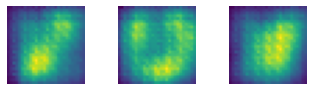

Epoch 1


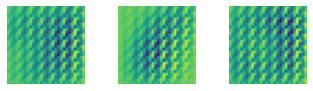

Epoch 2


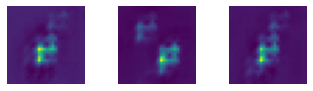

Epoch 3


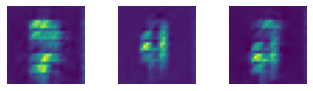

Epoch 4


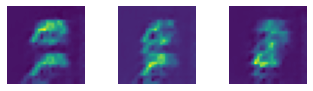

Epoch 5


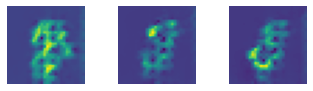

Epoch 6


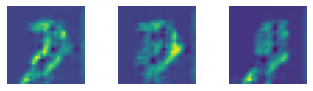

Epoch 7


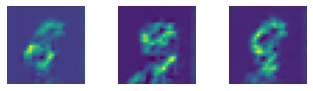

Epoch 8


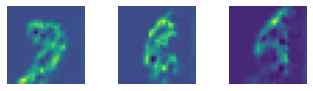

Epoch 9


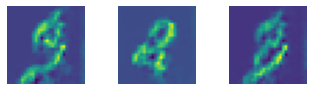

Epoch 10


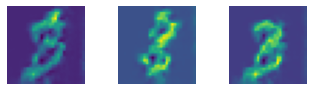

Epoch 11


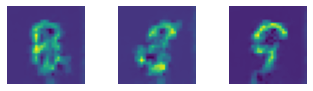

Epoch 12


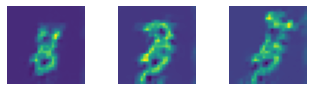

Epoch 13


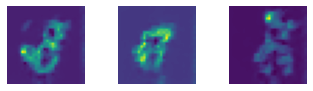

Epoch 14


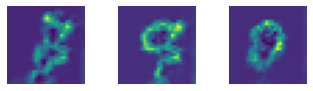

Epoch 15


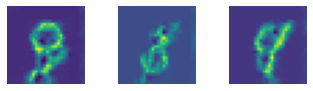

Epoch 16


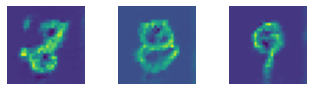

Epoch 17


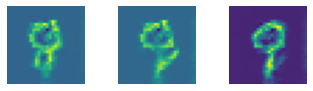

Epoch 18


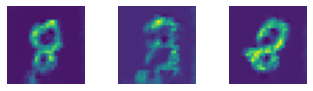

Epoch 19


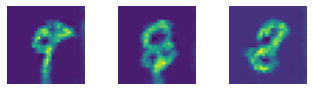

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [9]:
trainer = pl.Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=20,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
)

trainer.fit(model, dt_module)